# Packages and lib imports

In [1]:
# initial setup for any notebook

%load_ext autoreload
%autoreload 2
import sys
sys.path.append("/home/yarcoh/projects/thesis-code4") # go to parent dir

In [2]:
# imports

from src.deep.model_analyzer_src import ModelAnalyzer
from src.deep.models import *
from src.deep.trainers import Trainer
from src.general_methods.visualizer import Visualizer
from src.optics.config_manager import ConfigManager
import torchviz

from tqdm.notebook import tqdm
import os


# Parameters configuration

In [3]:
model_name = 'unet_v5_depth3_noiseless_b1_mu043_noreg_v1'
trained_model_path = '/data/yarcoh/thesis_data/data/test_models/'+model_name
main_ds_path = '/data/yarcoh/thesis_data/data/datasets/b1/noiseless/1000samples_20mu'
ds_subdir = 'mu=0.19'
# main_ds_path = '/data/yarcoh/thesis_data/data/datasets/100000samples_20mu/'
# ds_subdir = '100000_samples_mu=0.200'
datasetpath = os.path.join(main_ds_path, ds_subdir)

# Init

In [4]:
# load trainer from file
trainer: Trainer = Trainer.load3(trained_model_path)

In [5]:
conf = trainer.train_dataset.config
conf.__dict__


{'W': 0.05,
 'Nspans': 12,
 'La': 80,
 'M_QAM': 16,
 'Ts': 1.0,
 'Nos': 16,
 'eta': 2,
 'mu': 0.43157894736842106,
 'bet': 0.2,
 'with_ssf': True,
 'with_noise': False,
 'beta2': -21.0,
 'gamma': 1.27,
 'dz': 0.2,
 'K_T': 1.13,
 'chi': 0.0461,
 'verbose': False,
 'io_type': 'b1',
 'N_sc': 256,
 'T_guardband': 4750.0880922277665,
 'N_sc_raw': 237.50440461138834,
 'L': 960,
 'T0': 5120.0,
 'Tb': 10240.0,
 'Tn': 1358.1221810508403,
 'Zn': 87833.13612677579,
 'Pn': 8.964743939765935e-06,
 'Ns': 4096,
 'Nnft': 16384,
 'Tnft': 68266.66666666667,
 'dt': 4.166666666666667,
 'Nb': 2458,
 'T1': -25.132741228718345,
 'T2': 25.12967326714258,
 'XI': array([-511.9375,  512.    ])}

In [6]:
trainer.print_summary()

/home/yarcoh/projects/thesis-code4/src/deep/data_loaders.py:294: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484808560/work/torch/csrc/utils/tensor_new.cpp:201.)
  t = torch.Tensor([np_vec.real, np_vec.imag])


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 4, 4096]              28
              Tanh-2              [-1, 4, 4096]               0
         MaxPool1d-3              [-1, 4, 2048]               0
            Conv1d-4              [-1, 8, 2048]             104
              Tanh-5              [-1, 8, 2048]               0
         MaxPool1d-6              [-1, 8, 1024]               0
            Conv1d-7             [-1, 16, 1024]             400
              Tanh-8             [-1, 16, 1024]               0
         MaxPool1d-9              [-1, 16, 512]               0
  ConvTranspose1d-10              [-1, 8, 1024]             264
             Tanh-11              [-1, 8, 1024]               0
  ConvTranspose1d-12              [-1, 4, 2048]              68
             Tanh-13              [-1, 4, 2048]               0
  ConvTranspose1d-14              [-1, 

saved model architecture to /data/yarcoh/thesis_data/data/test_models/unet_v5_depth3_noiseless_b1_mu043_noreg_v1/_analyze/architecture.png


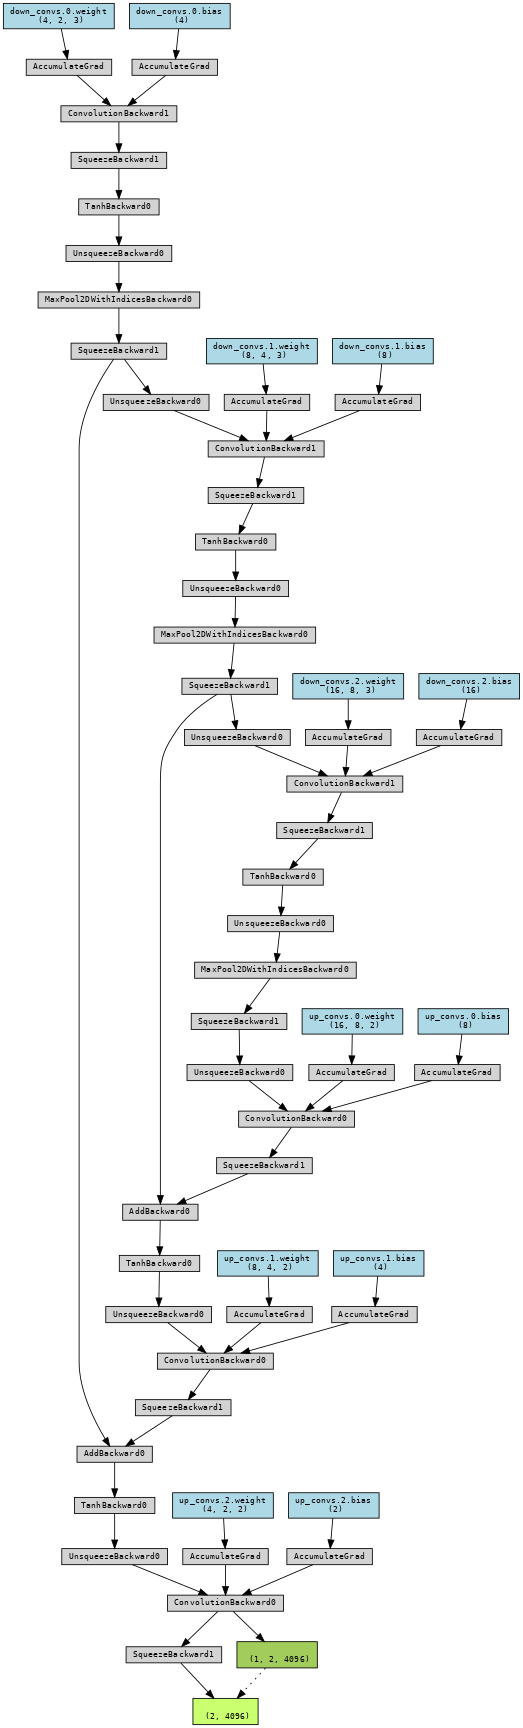

In [7]:
from IPython.display import Image
path = f'{trained_model_path}/_analyze/architecture'
trainer.plot_architecture(path)

# Replace 'image_path' with the path to your image file
Image(filename=path+'.png')


In [8]:
# for broken models with old config

# inp = input('Do you want to refresh config? (y/n) ')
# if inp == 'y':
#     trainer.train_dataset.config = ConfigManager.refresh_config(trainer.train_dataset.config)
#     trainer.save(trained_model_path)
# else:
#         print('config not refreshed')

In [9]:
ma: ModelAnalyzer = ModelAnalyzer(trainer,model_name)

In [10]:
ma.load_test_dataset(datasetpath, train_ds_ratio=0.4, val_ds_ratio=0.3, test_ds_ratio=0.3)

In [11]:
print(len(trainer.val_dataset))

300


In [12]:
#pretty print ds config


# Visualizer.print_config(trainer.val_dataset.config)

# analyze 1 sample

In [13]:
print(ma.cs_in.channel_config.io_type)

b1


In [14]:
# ma.plot_single_item(1)
# N = ma.cs_in.channel_config.Ns
# N = ma.cs_in.channel_config.N_sc
# ma.cs_in.channel_config.io_type
# ma.plot_single_item_together(i=1, zm_indices=range(N//2,N//2+50))

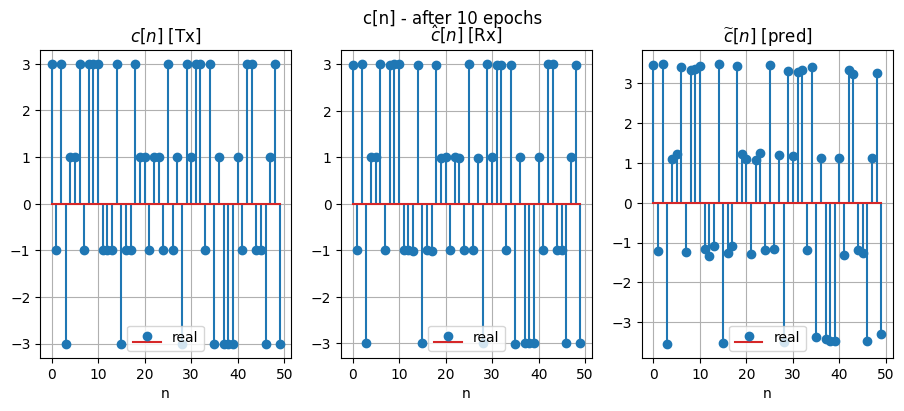

In [15]:
ma.plot_stems(i=1, zm_indices=range(0,50))

# analyze constelation

  0%|          | 0/40 [00:00<?, ?it/s]

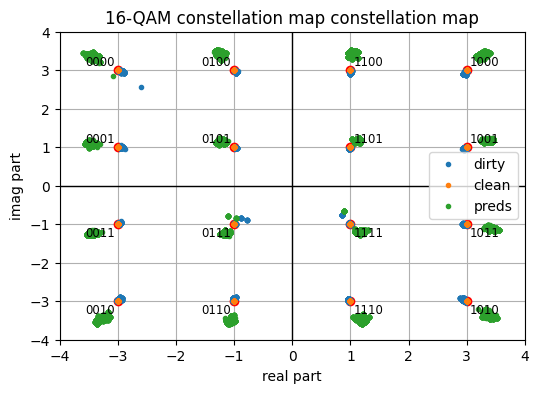

In [16]:
ma.plot_constelation(range(0,40))

In [17]:
# x_power_i, y_power, pred_power = ma.calc_norms(_tqdm=tqdm, verbose_level=1, max_items=10000)
# print(f'x_power: {x_power_i}\ny_power: {y_power}\npred_power: {pred_power}')

In [18]:
# ma.upload_single_item_plots_to_wandb(1)

In [19]:
ma.plot_bers(_tqdm=tqdm, verbose_level=1,num_x_per_folder=1000)

  0%|          | 0/300 [00:00<?, ?it/s]

the original avg ber (of validation set) is 0.0


  0%|          | 0/300 [00:00<?, ?it/s]

the trained avg ber (of validation set) is 0.0
the ber improvement is 0.00%


In [20]:
ma.upload_bers_to_wandb()

the original avg ber (of validation set) is 0.0
the trained avg ber (of validation set) is 0.0
the ber improvement is 0.00%


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: yarden92. Use `wandb login --relogin` to force relogin


# test all BERs

In [21]:
# add powers

# from apps.deep.power_adder import PowerAdder


# power_adder = PowerAdder(is_overright=True, verbose_level=2)
# power_adder.calculate_and_add_powers(main_ds_path)
# power_adder.replace_key_in_config_files(main_ds_path)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.100 | org_ber=0.00e+00 | model_ber=0.00e+00 |  ber_improve=000%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.150 | org_ber=0.00e+00 | model_ber=0.00e+00 |  ber_improve=000%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.190 | org_ber=0.00e+00 | model_ber=0.00e+00 |  ber_improve=000%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.240 | org_ber=0.00e+00 | model_ber=0.00e+00 |  ber_improve=000%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.290 | org_ber=0.00e+00 | model_ber=2.34e-05 |  ber_improve=000%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.340 | org_ber=0.00e+00 | model_ber=1.35e-04 |  ber_improve=000%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.380 | org_ber=2.24e-03 | model_ber=4.42e-03 |  ber_improve=-97%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.430 | org_ber=1.06e-02 | model_ber=2.67e-02 |  ber_improve=-153%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.480 | org_ber=3.46e-02 | model_ber=8.56e-02 |  ber_improve=-148%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.530 | org_ber=6.93e-02 | model_ber=1.59e-01 |  ber_improve=-129%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.570 | org_ber=1.19e-01 | model_ber=2.02e-01 |  ber_improve=-70%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.620 | org_ber=1.71e-01 | model_ber=2.37e-01 |  ber_improve=-39%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.670 | org_ber=2.14e-01 | model_ber=2.63e-01 |  ber_improve=-23%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.720 | org_ber=2.41e-01 | model_ber=2.77e-01 |  ber_improve=-15%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.760 | org_ber=2.74e-01 | model_ber=2.98e-01 |  ber_improve=-09%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.810 | org_ber=3.02e-01 | model_ber=3.16e-01 |  ber_improve=-05%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.860 | org_ber=3.21e-01 | model_ber=3.28e-01 |  ber_improve=-02%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.910 | org_ber=3.36e-01 | model_ber=3.40e-01 |  ber_improve=-01%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.950 | org_ber=3.53e-01 | model_ber=3.55e-01 |  ber_improve=-01%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=1.000 | org_ber=3.55e-01 | model_ber=3.56e-01 |  ber_improve=-00%


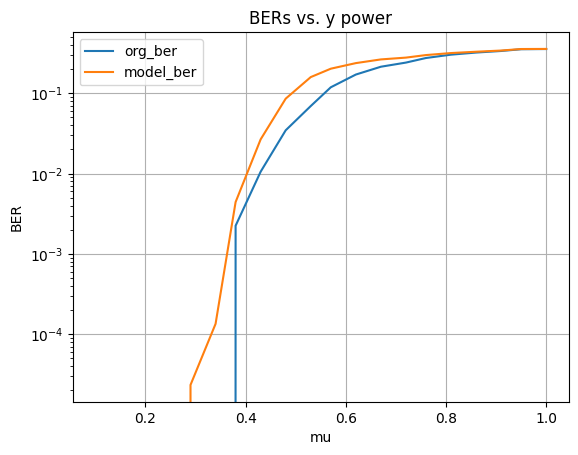

In [22]:
# main_ds_path = '/data/yarcoh/thesis_data/data/datasets/qam16_50x300/'

ma.plot_all_bers(base_path=main_ds_path, 
                 train_ds_ratio=0, 
                 val_ds_ratio=0, 
                 test_ds_ratio=0.5, 
                 _tqdm=tqdm, 
                 verbose_level=0.5)
                    

In [23]:
# upload to wandb
ma.upload_all_bers_to_wandb(base_path=main_ds_path,
                 train_ds_ratio=0, 
                 val_ds_ratio=0, 
                 test_ds_ratio=0.5, 
                 _tqdm=tqdm, 
                 verbose_level=0.5)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.1 ----------------
org_ber=0.0, model_ber=0.0, ber_improvement=0




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.15 ----------------
org_ber=0.0, model_ber=0.0, ber_improvement=0




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.19 ----------------
org_ber=0.0, model_ber=0.0, ber_improvement=0




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.24 ----------------
org_ber=0.0, model_ber=0.0, ber_improvement=0




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.29 ----------------
org_ber=0.0, model_ber=2.34375e-05, ber_improvement=0




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.34 ----------------
org_ber=0.0, model_ber=0.000134765625, ber_improvement=0




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.38 ----------------
org_ber=0.002244140625, model_ber=0.004421875, ber_improvement=-0.9704090513489989




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.43 ----------------
org_ber=0.01055859375, model_ber=0.026669921875, ber_improvement=-1.5258971513133555




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.48 ----------------
org_ber=0.03458203125, model_ber=0.085638671875, ber_improvement=-1.4763921834406417




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.53 ----------------
org_ber=0.06926953125, model_ber=0.158814453125, ber_improvement=-1.2927028703547059




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.57 ----------------
org_ber=0.1185625, model_ber=0.20194921875, ber_improvement=-0.7033144438587242




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.62 ----------------
org_ber=0.170791015625, model_ber=0.237021484375, ber_improvement=-0.38778660872548476




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.67 ----------------
org_ber=0.213701171875, model_ber=0.26348046875, ber_improvement=-0.2329388109491384




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.72 ----------------
org_ber=0.240634765625, model_ber=0.2774765625, ber_improvement=-0.1531025526561423




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.76 ----------------
org_ber=0.27438671875, model_ber=0.298443359375, ber_improvement=-0.08767421664792227




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.81 ----------------
org_ber=0.301916015625, model_ber=0.3161875, ber_improvement=-0.04726971620056809




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.86 ----------------
org_ber=0.320705078125, model_ber=0.328353515625, ber_improvement=-0.02384881943471719




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.91 ----------------
org_ber=0.33551953125, model_ber=0.339802734375, ber_improvement=-0.012765883133666375




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.95 ----------------
org_ber=0.352740234375, model_ber=0.35490625, ber_improvement=-0.00614054030110231




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=1.0 ----------------
org_ber=0.35463671875, model_ber=0.355912109375, ber_improvement=-0.003596329871016729




# THE END

In [24]:
# # paper 1 model analyzer
# path_init = '../../data/test_models/mu-0.008__128ds__PaperNNforNFTmodel__3epochs'

# trainer_real = Trainer.load3(path_init + '__real')
# trainer_imag = Trainer.load3(path_init + '__imag')

# train_ds = SingleMuDataSet(trainer_real.train_dataset.data_dir_path,
#                            trainer_real.train_dataset.data_indices)
# val_ds = SingleMuDataSet(trainer_real.val_dataset.data_dir_path,
#                          trainer_real.val_dataset.data_indices)

# model = PaperNNforNFTwrapper(trainer_real.model, trainer_imag.model)

# trainer = Trainer(
#     train_dataset=train_ds,
#     val_dataset=val_ds,
#     model=model,
#     device=trainer_real.device,
#     batch_size=trainer_real.train_dataloader.batch_size,
#     l_metric=trainer_real.l_metric,
#     optim=trainer_real.optim,
#     params=trainer_real.params)

In [25]:
# analyze on the whole dataset

# attach new dataset to trainer


In [26]:
# trainer.params

In [27]:
# ma = ModelAnalyzer(trainer)

In [28]:
# ma.plot_single_item(i=0)

In [29]:
# ma.plot_bers(_tqdm=tqdm)